## Preprocessing of police district data

### Preprocessing steps for ALL police districts:
#### 1. Process road network
1. Import polygons of the relevant counties/municipalities
2. Subtract polygons of the municipalities that are not part of the police district
3. Import OSMnx road network from the resulting polygon
4. Impute edge speeds and travel times
5. Compute node centrality -> save as CSV
6. Save road network (with edge speeds and travel times) as GraphML

#### 2. Process population data
1. Subtract polygons of the municipalities that are not part of the police district
2. Import and clip population data to the resulting polygon
3. Save population data as GeoJSON

#### General notes:
- Save and Load all data in the default CRS: WGS84 (EPSG:4326)
- Transform data to correct UTM zone when needed for analysis. UTM zone 33N (EPSG:32633)

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-16T14:48:32.270824+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import igraph as ig
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

networkx  : 3.2.1
geopandas : 0.14.3
matplotlib: 3.8.3
shapely   : 2.0.3
pulp      : 2.8.0
osmnx     : 1.9.1
igraph    : 0.11.4
pandas    : 2.2.1
pandana   : 0.7
numpy     : 1.26.4
pyproj    : 3.6.1



### 1. Process road network

Preprocessing steps for Øst police district as an example:
1. Import polygons of Akershus and Østfold counties
2. Subtract polygons of Asker, Bærum, Jevnaker and Lunner
3. Import OSMnx road network from the resulting polygon
4. Impute edge speeds and travel times
5. Compute node centrality -> save as CSV
6. Change graph CRS from WGS84 to UTM33N 
7. Save the network to a file -> save as GraphML

In [3]:
### Road network file of Øst police district, Norway

# 1) Read from local path
# akershus_filepath = "../data/AkershusDriveImputed.graphml" # with travel time attribute
# akershus_graph = ox.load_graphml(akershus_filepath) # originally in WGS84 (EPSG:4326)

# 2) Fetch from OSM - using OSMnx 
# akershus_graph = ox.graph_from_place('Akershus, Norway', network_type="drive") # originally in WGS84 (EPSG:4326)

In [4]:
# Step 1. Import polygons of Akershus and Østfold counties

# Fetch individual geodataframes for each place
akershus_gdf = ox.geocode_to_gdf("Akershus, Norway")
ostfold_gdf = ox.geocode_to_gdf("Østfold, Norway")

asker_gdf = ox.geocode_to_gdf("Asker, Norway")
barum_gdf = ox.geocode_to_gdf("Bærum, Norway")
jevnaker_gdf = ox.geocode_to_gdf("Jevnaker, Norway")
lunner_gdf = ox.geocode_to_gdf("Lunner, Norway")

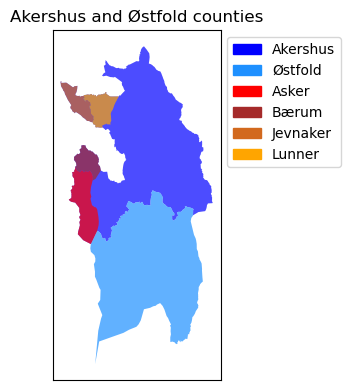

In [5]:
# Concatenate the geodataframes
counties_gdf = pd.concat([akershus_gdf, ostfold_gdf, asker_gdf, barum_gdf, jevnaker_gdf, lunner_gdf], axis=0)

# Plot the counties
# Set the figure size
fig, ax = plt.subplots(figsize=(3, 4))  # Adjust the size values as needed
colors = ['blue', 'dodgerblue', 'red', 'brown', 'chocolate', 'orange']
counties_gdf.plot(ax=ax, color=colors, alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

legend_labels = ['Akershus', 'Østfold', 'Asker', 'Bærum', 'Jevnaker', 'Lunner']
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 10})
plt.title('Akershus and Østfold counties')
plt.tight_layout()
plt.show()

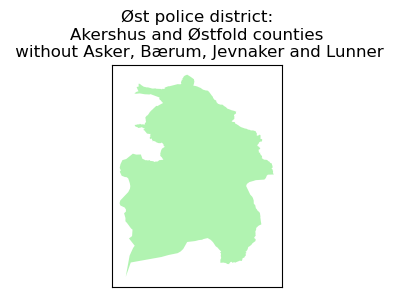

In [6]:
# Step 2. Subtract polygons of Asker, Bærum, Jevnaker and Lunner from Akershus and Østfold counties

# combine Akershus and Østfold polygons
combined_poly = unary_union([akershus_gdf.iloc[0].geometry, ostfold_gdf.iloc[0].geometry])

# subtract the polygons of Asker, Bærum, Jevnaker and Lunner from the combined polygon
for gdf in [asker_gdf, barum_gdf, jevnaker_gdf, lunner_gdf]:
    combined_poly = combined_poly.difference(gdf.iloc[0].geometry)

# plot the resulting polygon
fig, ax = plt.subplots(figsize=(2,4))  # Adjust the size values as needed
gpd.GeoSeries(combined_poly).plot(ax=ax, color='lightgreen', alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Øst police district:\nAkershus and Østfold counties\n without Asker, Bærum, Jevnaker and Lunner')
plt.tight_layout(); plt.show()

Now we have the polygon for the Øst police district. Note that this polygon does not have any coordinate system (CRS) info, we have to add this.   
For GeoDataFrames, we simply use the `to_crs` method, while for shapely polygons we use the `pyproj` library.

In [7]:
# Step 3. Import OSMnx road network from the resulting polygon
ost_graph = ox.graph_from_polygon(combined_poly, network_type="drive", simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)

type:  <class 'networkx.classes.multidigraph.MultiDiGraph'>
crs:   epsg:4326


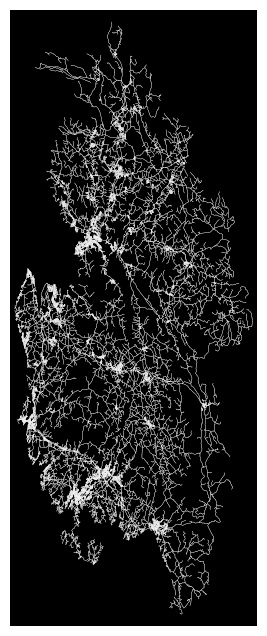

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
print("type: ", type(ost_graph))
print("crs:  ", ost_graph.graph['crs'])

# Plot the road network
ox.plot_graph(ost_graph, node_size=0, edge_color="w", edge_linewidth=0.2, bgcolor="k")

In [9]:
# Step 4. Impute edge speeds and travel times

# Convert the graph to node and edge GeoPandas GeoDataFrames
ost_gdf_nodes, ost_gdf_edges = ox.graph_to_gdfs(ost_graph)
print(f"type of ost_gdf_nodes:{type(ost_gdf_nodes)}")
ost_gdf_edges.head(2)

type of ost_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u         v          key                                      
265629056 8595477415 0    [629271201, 120466454, 926242999]   
          8595512022 0               [926242773, 110781343]   

                                                 name       highway  oneway  \
u         v          key                                                      
265629056 8595477415 0    [Vadholmen, Storesandveien]  unclassified   False   
          8595512022 0                      Storveien       primary   False   

                         reversed   length  \
u         v          key                     
265629056 8595477415 0       True 1061.374   
          8595512022 0      False  435.557   

                                                                   geometry  \
u         v          key                                                      
265629056 8595477415 0    LINESTRING (11.02541 59.03108, 11.02536 59.031...   
          8595512022 0    LINESTRING (11.02541 59.03108, 11.02547 59.031...   

                          ref  maxspeed bridge lanes junction tunnel width  \
u         v          key                                                     
265629056 8595477415 0    NaN       NaN    NaN   NaN      NaN    NaN   NaN   
          8595512022 0    108  [60, 40]    NaN   NaN      NaN    NaN   NaN   

                         access est_width  
u         v          key                   
265629056 8595477415 0      NaN       NaN  
          8595512022 0      NaN       NaN

In [10]:
# Select a subset of columns - before imputing edge speeds
subset_columns = ['lanes', 'name', 'highway', 'oneway', 'reversed', 'length', 'maxspeed', 'ref', 'junction', 'bridge', 'width', 'tunnel']
subset_gdf = ost_gdf_edges[subset_columns]
subset_gdf.head(4)

# impute speed on all edges missing data
ost_graph = ox.speed.add_edge_speeds(ost_graph)

# calculate travel time (seconds) for all edges
ost_graph = ox.speed.add_edge_travel_times(ost_graph)

# converting graph to node and edge GeoPandas GeoDataFrames
ost_gdf_nodes, ost_gdf_edges = ox.graph_to_gdfs(ost_graph)
print(f"type of ost_gdf_nodes:{type(ost_gdf_nodes)}")
ost_gdf_edges.keys()

type of ost_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'geometry',
       'speed_kph', 'travel_time', 'ref', 'maxspeed', 'bridge', 'lanes',
       'junction', 'tunnel', 'width', 'access', 'est_width'],
      dtype='object')

Here we verify the edges has new attributes: `speed_kph` and `travel_time`.

Next is computing the closeness centrality for each node in the network. This is a measure of how central a node is in the network. It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network. The higher the value, the more central the node is.   
Current implementation uses the `networkx` library, which is quite slow and memory intensive for this operation. At least it is only computed once and saved to a CSV file.   
TODO: Implement a faster method for computing centrality.

In [11]:
%%time
# 5. Compute node centrality - using NetworkX (suitable for small graphs)
# Calculate closeness centrality
# ost_centrality = nx.closeness_centrality(ost_graph, distance='travel_time')
# ost_gdf_nodes['closeness_centrality'] = ost_gdf_nodes.index.map(ost_centrality)

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
# 5. Compute node centrality - using igraph (suitable for large graphs)

# converting the networkx graph to an igraph graph
osmids = list(ost_graph.nodes)
ost_graph = nx.relabel.convert_node_labels_to_integers(ost_graph)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(ost_graph.nodes, osmids)}
nx.set_node_attributes(ost_graph, osmid_values, "osmid")

In [13]:
%%time
# convert networkx graph to igraph
ost_igraph= ig.Graph(directed=True)
ost_igraph.add_vertices(ost_graph.nodes)
ost_igraph.add_edges(ost_graph.edges())
ost_igraph.vs["osmid"] = osmids
ost_igraph.es["travel_time"] = list(nx.get_edge_attributes(ost_graph, "travel_time").values())

CPU times: total: 93.8 ms
Wall time: 231 ms


In [14]:
assert len(ost_graph.nodes()) == ost_igraph.vcount()
assert len(ost_graph.edges()) == ost_igraph.ecount()

In [15]:
# check for any non-positive travel time values
non_positive_edges = [e for e in ost_igraph.es if e["travel_time"] <= 0]
print(f"Number of non-positive travel time edges: {len(non_positive_edges)}")

# show the non-positive travel time edges
non_positive_edges[:]

# inspect the non-positive travel time edges, if small we can set them to a small positive value
for e in non_positive_edges:
    print(e.tuple, e["travel_time"])

# Set the non-positive travel time edges to a small positive value
for e in non_positive_edges:
    e["travel_time"] = 1

# Re-check for any non-positive travel time values
non_positive_edges = [e for e in ost_igraph.es if e["travel_time"] <= 0]
print(f"Number of non-positive travel time edges (2nd time): {len(non_positive_edges)}")

# this returned 6 non-positive travel time edges. This can happen when the travel time is not imputed for some edges.
# We can either remove these edges or impute the travel time for them. Here we added a small positive value to the travel time.

Number of non-positive travel time edges: 6
(24928, 24814) 0.0
(30309, 30496) 0.0
(30496, 30309) 0.0
(30681, 30680) 0.0
(33395, 27684) 0.0
(40906, 37894) 0.0
Number of non-positive travel time edges (2nd time): 0


In [16]:
%%time
# closeness centrality with igraph - incoming and outgoing paths
closeness1 = ost_igraph.closeness(vertices=None, mode="all", cutoff=None, weights="travel_time", normalized=True)
max_closeness1 = np.argmax(closeness1)

CPU times: total: 4min 15s
Wall time: 5min 19s


In [17]:
# inspect the maximum closeness centrality value
print(f"Max closeness centrality (1st method): {max_closeness1}, {closeness1[max_closeness1]}")

Max closeness centrality (1st method): 18646, 0.00038471712114844145


In [18]:
# adding the closeness centrality values to the node GeoDataFrame
ost_gdf_nodes["closeness_centrality"] = closeness1 # all nodes

In [19]:
ost_gdf_nodes.head(2)

,y,x,street_count,highway,ref,geometry,closeness_centrality
osmid,,,,,,,
265629056,59.031,11.025,3,NaN,NaN,POINT (11.02541 59.03108),0.000
267968013,59.105,10.844,3,NaN,NaN,POINT (10.84353 59.10482),0.000


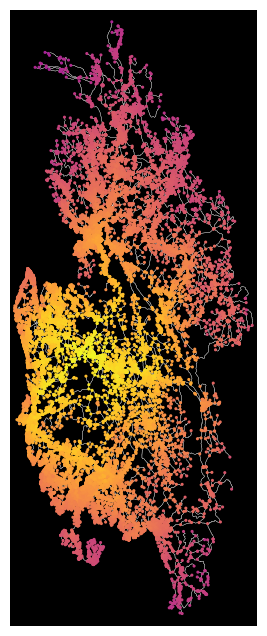

In [20]:
# Plot the road network with the closeness centrality values as node colors - using OSMnx
# node_color
nc = ost_gdf_nodes["closeness_centrality"]
nc = nc / nc.max()
nc = plt.cm.plasma(nc)

# plot the road network with the closeness centrality values as node colors
fig, ax = ox.plot_graph(ost_graph, node_size=5, node_color=nc, edge_color="w", edge_linewidth=0.2, bgcolor="k", show=False, close=False)
plt.show()

In [21]:
# Save centrality to CSV file with 'closeness_centrality' column and 'osmid' as index

# Prepare the node GeoDataFrame for saving to CSV file with 'closeness_centrality' columns and 'osmid' as index
ost_gdf_nodes_centrality = ost_gdf_nodes[["closeness_centrality"]]
ost_gdf_nodes_centrality.to_csv("../data/ost/OstNodeCentrality.csv")

# Load centrality from CSV file
ost_gdf_nodes_imported = pd.read_csv("../data/ost/OstNodeCentrality.csv", index_col=0)
ost_gdf_nodes_imported.head(2)

# print the single highest closeness centrality value
max_closeness = ost_gdf_nodes_imported["closeness_centrality"].max()
print(f"Max closeness centrality: {max_closeness}")

Max closeness centrality: 0.0003847171211484


In [22]:
ost_gdf_nodes_imported.head(2)

,closeness_centrality
osmid,
265629056,0.000
267968013,0.000


In [23]:
# 6. Save road network (with edge speeds and travel times) as GraphML

# # Save the graph to a file
# ost_filepath = "../data/ost/OstDriveImputed.graphml"
# ox.save_graphml(ost_graph, filepath=ost_filepath, gephi=False, encoding='utf-8') # with travel time attribute

The CRS of the road network have remained unchanged as WGS4 (EPSG:4326).   
Conversion to UTM33N (EPSG:32633) is done after importing the network and before any analysis.

### 2. Process population data
1. Import counties/municipalitiy population data for the police district.
2. Import and clip population data to the resulting polygon.
3. Save population data as GeoJSON.

In [24]:
# Step 1. Import counties/municipalitiy population data for the police district
# Load Akershus and Østfold population data
akershus_population_path = "../data/ost/SSB_ost_district/Akershus_wgs84_epsg4326/v_ru250m_2023_rutenett.geojson"
ostfold_population_path = "../data/ost/SSB_ost_district/Ostfold_wgs84_epsg4326/v_ru250m_2023_rutenett.geojson"
akershus_population = gpd.read_file(akershus_population_path)
ostfold_population = gpd.read_file(ostfold_population_path)
akershus_population.columns = ['id', 'population', 'geometry'] # rename column names
ostfold_population.columns = ['id', 'population', 'geometry'] # rename column names

In [46]:
# Step 2. Import and clip population data to the resulting polygon.
# Already have 'combined_poly' from previous steps to clip the population data

# combine the population data for Akershus and Østfold
population_gdf = pd.concat([akershus_population, ostfold_population], axis=0)

# clip the population data to the resulting polygon
clipped_population = gpd.clip(population_gdf, combined_poly)

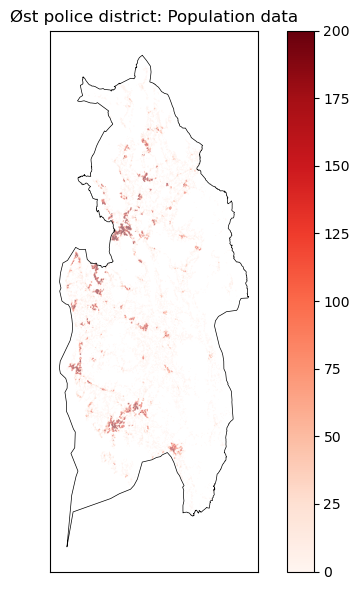

In [47]:
# plot the clipped population data, with the combined polygon as outline and the population colored by population size
fig, ax = plt.subplots(figsize=(6,6))  # Adjust the size values as needed
combined_poly_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(combined_poly))
combined_poly_gdf.boundary.plot(ax=ax, color='k', linewidth=0.5)

# set custom range for the color map
vmin, vmax = 0, 200
clipped_population.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
# clipped_population.plot(ax=ax, column='population', cmap='jet', legend=True, alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Øst police district: Population data')
plt.tight_layout(); plt.show()

In [48]:
# Step 3. Save population data as GeoJSON.

# # Save the clipped population data to a file
# clipped_population.to_file("../data/ost/OstPopulation.geojson", driver="GeoJSON")

# # load the population data from the file
# clipped_population_imported = gpd.read_file("../data/ost/OstPopulation.geojson")
# clipped_population_imported.head(2)

,id,population,geometry
0,22735006545750,4,"POLYGON ((11.05715 58.99115, 11.05689 58.99339..."
1,22737506546000,2,"POLYGON ((11.06123 58.99352, 11.06098 58.99576..."


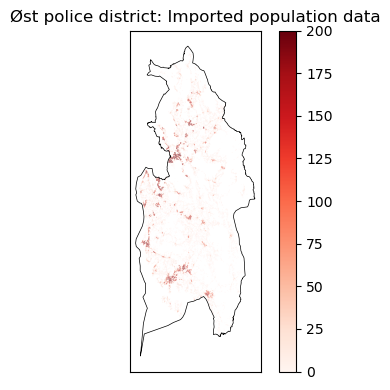

In [50]:
# plot the imported population data for verification
fig, ax = plt.subplots(figsize=(4,4))  # Adjust the size values as needed
combined_poly_gdf.boundary.plot(ax=ax, color='k', linewidth=0.5)
clipped_population_imported.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Øst police district: Imported population data')
plt.tight_layout(); plt.show()